In [1]:
# XGBoost Model for improvement
!pip install xgboost


In [2]:
!pip -q install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv(r"M:/MVG/Courses/Predicting_Student_Test_SCore/playground-series-s6e1/train.csv")
test = pd.read_csv(r"M:/MVG/Courses/Predicting_Student_Test_SCore/playground-series-s6e1/test.csv")

print(train.shape)
train.head()

(630000, 13)


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
TARGET = "exam_score"
train[TARGET].describe()

count    630000.000000
mean         62.506672
std          18.916884
min          19.599000
25%          48.800000
50%          62.600000
75%          76.300000
max         100.000000
Name: exam_score, dtype: float64

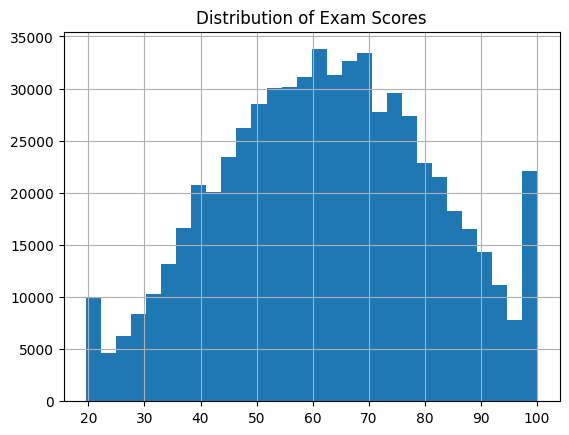

In [5]:
train[TARGET].hist(bins=30)
plt.title("Distribution of Exam Scores")
plt.show()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [7]:
train.isna().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [8]:
print("Duplicates: ", train.duplicated().sum())
train = train.drop_duplicates()

Duplicates:  0


In [9]:
for col in train.columns:
    if col == TARGET:
        continue

    if train[col].dtype == "object":
        mode_val = train[col].mode()[0]
        train[col] = train[col].fillna(mode_val)
        test[col]  = test[col].fillna(mode_val)
    else:
        median_val = train[col].median()
        train[col] = train[col].fillna(median_val)
        test[col]  = test[col].fillna(median_val)


In [10]:
ord_maps = {
    "sleep_quality": {"poor": 0, "average": 1, "good": 2},
    "facility_rating": {"low": 0, "medium": 1, "high": 2},
    "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2}
}

for col, mp in ord_maps.items():
    train[col] = train[col].map(mp)
    test[col]  = test[col].map(mp)


In [11]:
for df in (train, test):
    df["study_attend"] = df["study_hours"] * df["class_attendance"]
    df["sleep_score"]  = df["sleep_hours"] * df["sleep_quality"]
    df["study2"]       = df["study_hours"] ** 2


In [12]:
# Mean target encoding (simple and effective)
course_mean = train.groupby("course")[TARGET].mean()
train["course_mean_score"] = train["course"].map(course_mean)
test["course_mean_score"]  = test["course"].map(course_mean)

# If any unseen category in test (rare), fill with global mean
global_mean = train[TARGET].mean()
test["course_mean_score"] = test["course_mean_score"].fillna(global_mean)


In [13]:
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_test = test.copy()

X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

print(X.shape, X_test.shape)


(630000, 25) (270000, 25)


In [14]:
Y_MIN, Y_MAX = y.min(), y.max()

In [15]:
# Linear Regression (Ridge)
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [16]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_oof = np.zeros(len(X))

for fold, (tr_idx, va_idx) in enumerate(kf.split(X), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_tr, y_tr)

    ridge_oof[va_idx] = ridge.predict(X_va)
    print(f"Fold {fold} RMSE: {rmse(y_va, ridge_oof[va_idx]):.5f}")

print("Ridge CV RMSE:", rmse(y, ridge_oof))


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27141e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 1 RMSE: 8.88585


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27269e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 2 RMSE: 8.89055


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.26871e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 3 RMSE: 8.88409


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.2733e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 4 RMSE: 8.89678
Fold 5 RMSE: 8.91234
Ridge CV RMSE: 8.893925135503716


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27248e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [18]:
cat = CatBoostRegressor(
    loss_function="RMSE",
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=0
)
cat.fit(X, y)
cat_test_pred = cat.predict(X_test)


In [19]:
oof = np.zeros(len(X))

for fold, (tr_idx, va_idx) in enumerate(kf.split(X), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    # Step 1: Ridge on training fold
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_tr, y_tr)

    ridge_tr_pred = ridge.predict(X_tr)
    ridge_va_pred = ridge.predict(X_va)

    # Step 2: Residuals (train fold ONLY)
    resid_tr = y_tr - ridge_tr_pred

    # Step 3: XGBoost on residuals
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        gamma=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"
    )

    xgb.fit(X_tr, resid_tr)

    # Final prediction
    # oof[va_idx] = ridge_va_pred + xgb.predict(X_va)
    fold_pred = ridge_va_pred + xgb.predict(X_va)
    oof[va_idx] = np.clip(fold_pred, Y_MIN, Y_MAX)


    print(f"Fold {fold} RMSE: {rmse(y_va, oof[va_idx]):.5f}")

print("Final Residual Boosting CV RMSE:", rmse(y, oof))


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27141e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 1 RMSE: 8.75740


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27269e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 2 RMSE: 8.76782


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.26871e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 3 RMSE: 8.75971


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.2733e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 4 RMSE: 8.77709


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.27248e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Fold 5 RMSE: 8.79192
Final Residual Boosting CV RMSE: 8.770796987440752


In [ ]:
# Train on full data
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

ridge_pred_train = ridge.predict(X)
resid = y - ridge_pred_train

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

xgb.fit(X, resid)

# test_pred = ridge.predict(X_test) + xgb.predict(X_test)
test_pred = ridge.predict(X_test) + xgb.predict(X_test)
test_pred = np.clip(test_pred, Y_MIN, Y_MAX)

# Blend (tune weights slightly if you want)
final_pred = 0.6 * test_pred + 0.4 * cat_test_pred
final_pred = np.clip(final_pred, Y_MIN, Y_MAX)


submission = pd.DataFrame({
    "id": test["id"],
    "exam_score": final_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()


c:\Users\MGOKAK\anaconda3\envs\tensorflowds\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=3.41737e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,id,exam_score
0,630000,72.270200
1,630001,69.833352
2,630002,86.616631
3,630003,55.964800
4,630004,46.375699


: 